In [1]:
!git clone https://github.com/fastai/fastai1.git

Cloning into 'fastai1'...
remote: Enumerating objects: 32981, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 32981 (delta 96), reused 198 (delta 92), pack-reused 32769
Receiving objects: 100% (32981/32981), 471.68 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (23993/23993), done.
Checking out files: 100% (816/816), done.


In [2]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 136 kB/s 


In [3]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') # switch off RDKit warning messages

from sklearn.model_selection import train_test_split

from fastai1.fastai import *
from fastai1.fastai.text import *
from fastai1.fastai.vision import *

import numpy as np
import threading
import random
from sklearn.utils import shuffle 

In [5]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Create a path to save the results
from pathlib import Path

data_path = Path('/content/gdrive/MyDrive/AI /Drug Discovery/TL_Catalysis_Code/results')
name = 'regressor_10'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

In [8]:
import pandas as pd

data = pd.read_csv('/content/gdrive/MyDrive/AI /Drug Discovery/TL_Catalysis_Code/Data/Fine-Tuning/reaction-1.csv')
print('Dataset:', data.shape)

Dataset: (4132, 2)


In [59]:
data

,smiles,yield
0,CC(C)c1cc(C(C)C)cc(C(C)C)c1c1c(P(C2CCCCC2)C2CC...,10.657812
1,CC(C)c1cc(C(C)C)cc(C(C)C)c1c1c(P(C2CCCCC2)C2CC...,14.747896
2,CC(C)c1cc(C(C)C)cc(C(C)C)c1c1c(P(C2CCCCC2)C2CC...,18.278686
3,CC(C)c1cc(C(C)C)cc(C(C)C)c1c1c(P(C2CCCCC2)C2CC...,2.475058
4,CC(C)c1cc(C(C)C)cc(C(C)C)c1c1c(P(C2CCCCC2)C2CC...,6.119058
...,...,...
4127,CC(c1c(c2c(OC)ccc(OC)c2P(C23CC4CC(C2)CC(C4)C3)...,57.426670
4128,CC(c1c(c2c(OC)ccc(OC)c2P(C23CC4CC(C2)CC(C4)C3)...,86.233157
4129,CC(c1c(c2c(OC)ccc(OC)c2P(C23CC4CC(C2)CC(C4)C3)...,1.440081
4130,CC(c1c(c2c(OC)ccc(OC)c2P(C23CC4CC(C2)CC(C4)C3)...,43.538365


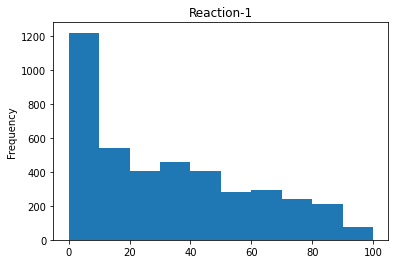

In [53]:
data['yield'].plot.hist(title='Reaction-1',bins=10)

In [45]:
data2 = pd.read_excel('/content/gdrive/MyDrive/AI /Drug Discovery/TL_Catalysis_Code/Data/Fine-Tuning/reaction-2.xlsx')
print('Dataset:', data2.shape)

Dataset: (1075, 2)


In [57]:
data2

,smiles,ee
0,O=P1(O)OC2=C(C3=C(F)C=C(OC)C=C3F)C=C4C(C=CC=C4...,1.531803
1,O=P1(O)OC2=C(C3=C(F)C=C(OC)C=C3F)C=C4C(C=CC=C4...,0.981981
2,O=P1(O)OC2=C(C3=C(F)C=C(OC)C=C3F)C=C4C(C=CC=C4...,1.074991
3,O=P1(O)OC2=C(C3=C(F)C=C(OC)C=C3F)C=C4C(C=CC=C4...,1.370104
4,O=P1(O)OC2=C(C3=C(F)C=C(OC)C=C3F)C=C4C(C=CC=C4...,1.446325
...,...,...
1070,O=P1(O)OC2=C(C3=C(OC)C=CC=C3OC)C=C4C(C=CC=C4)=...,1.964153
1071,O=P1(O)OC2=C(C3=C(OC)C=CC=C3OC)C=C4C(C=CC=C4)=...,1.074991
1072,O=P1(O)OC2=C(C3=C(OC)C=CC=C3OC)C=C4C(C=CC=C4)=...,1.531803
1073,O=P1(O)OC2=C(C3=C(OC)C=CC=C3OC)C=C4C(C=CC=C4)=...,2.304684


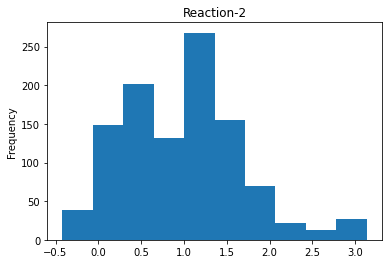

In [56]:
data2['ee'].plot.hist(title='Reaction-2',bins=10)

In [50]:
data3 = pd.read_csv('/content/gdrive/MyDrive/AI /Drug Discovery/TL_Catalysis_Code/Data/Fine-Tuning/reaction-3.csv')
print('Dataset:', data3.shape)

Dataset: (368, 2)


In [60]:
data3

,smiles,ee
0,c1cc2c(c3c1op(oc1c3c3ccccc3cc1)OC)cccc2.C=C(CC...,89.2
1,c1cc2c(c3c1op(oc1c3c3ccccc3cc1)OC(C)C)cccc2.C=...,97.6
2,c1cc2c(c3c1op(oc1c3c3ccccc3cc1)Oc1ccccc1)cccc2...,96.6
3,c1cc2c(c3c1op(oc1c3c3ccccc3cc1)Oc1ccccc1Br)ccc...,89.8
4,c1cc2c(c3c1op(oc1c3c3ccccc3cc1)O[C@H](c1ccccc1...,99.2
...,...,...
363,c1(cc2c(c3-c4c(c(cc5c4cccc5)[Si](c4ccccc4)(c4c...,93.0
364,c1(cc2c(c3-c4c(c(cc5c4cccc5)[Si](c4ccccc4)(c4c...,96.0
365,c1(cc2c(c3-c4c(c(cc5c4cccc5)[Si](c4ccccc4)(c4c...,98.0
366,c1(cc2c(c3-c4c(c(cc5c4cccc5)[Si](c4ccccc4)(c4c...,93.0


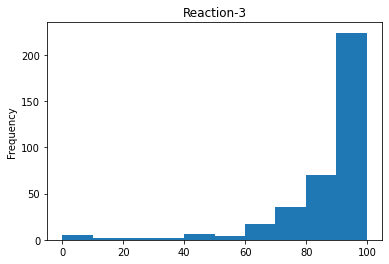

In [52]:
data3['ee'].plot.hist(xlabel='yield',title='Reaction-3',bins=10)

In [9]:
random_seed(1234, True)

train_ , test = train_test_split(data, test_size=0.20, random_state=100)
train, valid = train_test_split(train_, test_size=0.125, random_state=0)
print(train.shape)
print(test.shape)
print(valid.shape)

(2891, 2)
(827, 2)
(414, 2)


In [10]:
def randomize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False)

In [11]:
# For Reaction-3 'yield' is replaced by 'ee'.
def ee_smiles_augmentation(df, N_rounds, noise):
    '''
    noise: add gaussion noise to the label
    '''
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['yield'].append(df.iloc[i]['yield'] + np.random.normal(0,noise))
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

In [12]:
%%time 
random_seed(1234, True)

# changed 100 to 50
train_aug = ee_smiles_augmentation(train, 100, noise=0.5)
print("Train_aug: ", train_aug.shape)

Train_aug:  (291990, 2)
CPU times: user 5min 31s, sys: 1.3 s, total: 5min 32s
Wall time: 5min 31s


In [13]:
# Don't include the defalut specific token of fastai, only keep the padding token
BOS,EOS,FLD,UNK,PAD = 'xxbos','xxeos','xxfld','xxunk','xxpad'
TK_MAJ,TK_UP,TK_REP,TK_WREP = 'xxmaj','xxup','xxrep','xxwrep'
defaults.text_spec_tok = [PAD]

special_tokens = ['[BOS]', '[C@H]', '[C@@H]','[C@]', '[C@@]','[C-]','[C+]', '[c-]', '[c+]','[cH-]',
                   '[nH]', '[N+]', '[N-]', '[n+]', '[n-]' '[NH+]', '[NH2+]',
                   '[O-]', '[S+]', '[s+]', '[S-]', '[O+]', '[SH]', '[B-]','[BH2-]', '[BH3-]','[b-]',
                   '[PH]','[P+]', '[I+]', 
                  '[Si]','[SiH2]', '[Se]','[SeH]', '[se]', '[Se+]', '[se+]','[te]','[te+]', '[Te]']

class MolTokenizer(BaseTokenizer):
    def __init__(self, lang = 'en', special_tokens = special_tokens):
        self.lang = lang
        self.special_tokens = special_tokens
        
    def tokenizer(self, smiles):
        # add specific token '[BOS]' to represetences the start of SMILES
        smiles = '[BOS]' + smiles
        regex = '(\[[^\[\]]{1,10}\])'
        char_list = re.split(regex, smiles)
        tokens = []
        
        if self.special_tokens:
            for char in char_list:
                if char.startswith('['):
                    if char in special_tokens:
                        tokens.append(str(char))
                    else:
                        tokens.append('[UNK]')
                else:
                    chars = [unit for unit in char]
                    [tokens.append(i) for i in chars]                    
        
        if not self.special_tokens:
            for char in char_list:
                if char.startswith('['):
                    tokens.append(str(char))
                else:
                    chars = [unit for unit in char]
                    [tokens.append(i) for i in chars]
                
        #fix the 'Br' be splited into 'B' and 'r'
        if 'B' in tokens:
            for index, tok in enumerate(tokens):
                if tok == 'B':
                    if index < len(tokens)-1: # make sure 'B' is not the last character
                        if tokens[index+1] == 'r':
                            tokens[index: index+2] = [reduce(lambda i, j: i + j, tokens[index : index+2])]
        
        #fix the 'Cl' be splited into 'C' and 'l'
        if 'l' in tokens:
            for index, tok in enumerate(tokens):
                if tok == 'l':
                    if tokens[index-1] == 'C':
                            tokens[index-1: index+1] = [reduce(lambda i, j: i + j, tokens[index-1 : index+1])]
        return tokens    
    
    def add_special_cases(self, toks):
        pass

In [14]:
bs = 128
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=6, pre_rules=[], post_rules=[])

In [15]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Here also 'yield' is replaced with 'ee'. 

random_seed(1234, True)
data_clas = TextClasDataBunch.from_df(path, train_aug, valid, bs=bs, tokenizer=tok, 
                                          chunksize=50000, text_cols='smiles',label_cols='yield', 
                                          max_vocab=60000, include_bos=False, min_freq=1, num_workers=0)

print(f'Vocab Size: {len(data_clas.vocab.itos)}')

Vocab Size: 32


In [16]:
random_seed(1234, True)

reg_learner = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.0, metrics = [rmse, r2_score])
reg_learner.unfreeze()

In [17]:
# Model architecture
reg_learner.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(32, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(32, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1200, out_features=50, bias=True)
      (2): ReLU(inplace=True)
      (3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_run

In [18]:
# To turn off the warning in "VisibleDeprecationwarning"
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

random_seed(1234, True)

lr = 1e-3

# I have changed it to one epoch instead of 15 epoch. 
reg_learner.fit_one_cycle(3, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,152.443939,149.295456,12.165602,0.784583,14:06
1,52.094421,39.244392,6.195503,0.944005,14:50
2,47.640232,31.617060,5.560662,0.954944,14:39


In [19]:
split_id = 10  # This Id is for TL_m0_reaction-1
reg_learner.save(f'{split_id}_reg')

In [20]:
# Please inport test_augmentaion function from TL_m1 file.
def test_smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['yield'].append(df.iloc[i]['yield'])
    df_aug = pd.DataFrame.from_dict(dist_aug)
    
    return pd.DataFrame.from_dict(dist_aug)

In [21]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

preds = []

# Randomized SMILES Predictions
for i in range(4):
    np.random.seed(12*i)
    # Please use "test_smiles_augmentaion" function 
    test_aug = test_smiles_augmentation(test,1)

    # above, I have changed test_smiles_augmentation to smiles augmentation. 

    #model (yeild changed to ee)
    test_db = TextClasDataBunch.from_df(path, train, test_aug, tokenizer=tok, vocab=data_clas.vocab,
                                            text_cols='smiles', label_cols='yield', bs=bs, include_bos=False)
    learner = text_classifier_learner(test_db, AWD_LSTM, pretrained=False, drop_mult=0.0, metrics = [r2_score, rmse])
    
    learner.load(f'{split_id}_reg'); 
  
    #get predictions
    pred,lbl = learner.get_preds(ordered=True)
    
    preds.append(pred)
    
# Canonical SMILES Predictions


test_db = TextClasDataBunch.from_df(path, train, test, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols='smiles',label_cols='yield', vocab=data_clas.vocab, max_vocab=60000,
                                              include_bos=False)

learner = text_classifier_learner(test_db, AWD_LSTM, pretrained=False, drop_mult=0.0, metrics = [r2_score, rmse])

learner.load(f'{split_id}_reg');

#get predictions
pred_canonical,lbl2 = learner.get_preds(ordered=True)
    

#preds.append(pred_canonical)
#preds 

In [22]:
print('Test Set (Canonical)')
print('RMSE:', root_mean_squared_error(pred_canonical,lbl2))
print('R2:', r2_score(pred_canonical,lbl2))
print('MAE:', mean_absolute_error(pred_canonical,lbl2))

avg_preds = sum(preds)/len(preds)
#print('\n')
print('Test Set (Average)')
print('RMSE:', root_mean_squared_error(avg_preds,lbl))
print('R2:', r2_score(avg_preds,lbl))
print('MAE:', mean_absolute_error(avg_preds,lbl))

Test Set (Canonical)
RMSE: tensor(6.2447)
R2: tensor(0.9479)
MAE: tensor(4.2450)
Test Set (Average)
RMSE: tensor(5.7691)
R2: tensor(0.9555)
MAE: tensor(3.9025)
